In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.mosaicplot import mosaic
from scipy import stats as spst
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [2]:
# mobile data
data_path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_NA2.csv"
mobile = pd.read_csv(data_path)
mobile.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,544,1,47711,183,17,730589.0,192,19,5,unsat,little,considering,0
1,689,0,74132,191,43,535092.0,349,15,2,unsat,very_little,no,1
2,3134,1,150419,0,14,204004.0,682,0,6,unsat,very_high,considering,0
3,12523,0,159567,0,58,281969.0,634,1,1,very_unsat,very_high,never_thought,0
4,2374,1,23392,0,0,216707.0,233,0,15,unsat,very_little,no,1


|변수 명|내용|구분|
|	----	|	----	|	----	|
|	COLLEGE	|	대학졸업 여부(1,0) - 범주	|		|
|	INCOME	|	연 수입액(달러)	|		|
|	OVERAGE	|	월 초과사용 시간(분)	|		|
|	LEFTOVER	|	월 사용 잔여시간비율(%)	|		|
|	HOUSE	|	집 가격(달러)	|		|
|	HANDSET_PRICE	|	핸드폰 가격(달러)	|		|
|	OVER_15MINS_CALLS_PER_MONTH	|	 평균 장기통화(15분 이상) 횟수	|		|
|	AVERAGE_CALL_DURATION	|	평균 통화시간(분)	|		|
|	REPORTED_SATISFACTION	|	만족도 설문('very_unsat', 'unsat', 'avg', 'sat', 'very_sat' ) - 범주	|		|
|	REPORTED_USAGE_LEVEL	|	사용 수준 설문('very_little', 'little', 'avg', 'high', 'very_high') - 범주	|		|
|	CONSIDERING_CHANGE_OF_PLAN	|	변경 계획 설문('never_thought', 'no', 'perhaps', 'considering',   'actively_looking_into_it') - 범주	|		|
|	**CHURN**	|	이탈여부(1 : 이탈, 0 : 잔류)	|	**Target**	|


In [3]:
df = mobile.copy()

In [4]:
df.tail(3)

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
17997,13354,0,82931,0,77,NaN,232,0,2,very_unsat,very_little,never_thought,0
17998,2421,0,124391,0,19,NaN,862,0,2,unsat,very_high,no,0
17999,2553,0,104849,223,5,NaN,463,21,5,very_unsat,little,considering,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           18000 non-null  int64  
 1   COLLEGE                      18000 non-null  int64  
 2   INCOME                       18000 non-null  int64  
 3   OVERAGE                      18000 non-null  int64  
 4   LEFTOVER                     18000 non-null  int64  
 5   HOUSE                        17785 non-null  float64
 6   HANDSET_PRICE                18000 non-null  int64  
 7   OVER_15MINS_CALLS_PER_MONTH  18000 non-null  int64  
 8   AVERAGE_CALL_DURATION        18000 non-null  int64  
 9   REPORTED_SATISFACTION        17962 non-null  object 
 10  REPORTED_USAGE_LEVEL         18000 non-null  object 
 11  CONSIDERING_CHANGE_OF_PLAN   18000 non-null  object 
 12  CHURN                        18000 non-null  int64  
dtypes: float64(1), i

In [6]:
#결측치 처리
df['HOUSE'].fillna(df['HOUSE'].mean(), inplace=True)
# 설문조사 이기때문에 최빈값으로 채움
df['REPORTED_SATISFACTION'].fillna('very_unsat', inplace=True)

In [7]:
df.isna().sum()

id                             0
COLLEGE                        0
INCOME                         0
OVERAGE                        0
LEFTOVER                       0
HOUSE                          0
HANDSET_PRICE                  0
OVER_15MINS_CALLS_PER_MONTH    0
AVERAGE_CALL_DURATION          0
REPORTED_SATISFACTION          0
REPORTED_USAGE_LEVEL           0
CONSIDERING_CHANGE_OF_PLAN     0
CHURN                          0
dtype: int64

In [8]:
target='CHURN'

변경계획설문(CONSIDERING_CHANGE_OF_PLAN)과 다른 컬럼

In [9]:
feature='CONSIDERING_CHANGE_OF_PLAN'

In [10]:
df[feature].value_counts()

considering                 7141
actively_looking_into_it    4453
no                          3644
never_thought               1804
perhaps                      958
Name: CONSIDERING_CHANGE_OF_PLAN, dtype: int64

In [11]:
all=df[feature].count()
all

18000

In [12]:
change=df[feature].loc[(df[feature]=='considering') | (df[feature]=='actively_looking_into_it')].count()
change

11594

In [13]:
print(round(change/all,2))

0.64


변경계획설문에서 긍정적으로 변경한다는 비율은 64%로 절반 이상의 고객이 변경을 염두해둠

### real집단 = 변경의사가 있고 실제 변경한 사람들
### fake집단 = 변경의사는 있지만 변경하지 않은 사람들

In [14]:
# 변경 의사가 있고 실제로 변경한 사람들 = real
real=df.loc[((df[feature]=='considering') | (df[feature]=='actively_looking_into_it'))&df[target]==1]
real

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
6,6337,1,99548,235,0,238561.000000,294,15,6,very_unsat,little,actively_looking_into_it,1
8,11134,1,133496,163,11,166179.000000,864,10,5,very_unsat,little,actively_looking_into_it,1
13,14755,0,125511,0,0,162564.000000,619,0,1,very_sat,high,considering,1
16,5294,0,116680,189,0,212073.000000,611,28,10,very_unsat,very_high,considering,1
23,555,0,42564,174,0,270823.000000,209,25,13,unsat,very_little,considering,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17981,19860,0,42235,260,19,492950.532696,146,12,6,avg,very_little,considering,1
17984,11568,0,103469,230,0,492950.532696,565,22,13,avg,little,actively_looking_into_it,1
17987,17077,1,44611,56,13,492950.532696,202,3,5,sat,little,actively_looking_into_it,1
17993,17217,1,72824,53,42,492950.532696,370,4,1,very_unsat,very_little,considering,1


In [15]:
print(round(5668/11594,2)*100)

49.0


변경을 염두하던 11594명 중 실제로 변경한 사람은 5668명
> 49%로 반도 안되는 인원이 변경하지 않음

그럼 변경을 생각했지만 변경하지 않은 사람(fake)들을 더 세밀분석해보자

만족도 설문 ('REPORTED_SATISFACTION')

In [16]:
# 변경 의사가 있지만 실제로 변경하지 않은 사람들 = fake
fake=df.loc[((df[feature]=='considering') | (df[feature]=='actively_looking_into_it'))&~(df[target]==1)]
fake

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,544,1,47711,183,17,730589.000000,192,19,5,unsat,little,considering,0
2,3134,1,150419,0,14,204004.000000,682,0,6,unsat,very_high,considering,0
5,17708,1,119591,0,43,231309.000000,714,1,1,very_sat,little,considering,0
9,11959,1,155145,29,18,717451.000000,671,4,4,unsat,high,considering,0
10,465,0,117558,40,6,403254.000000,263,3,6,very_unsat,very_high,considering,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17985,170,0,95617,197,32,492950.532696,315,19,2,avg,avg,considering,0
17986,19429,1,124818,62,0,492950.532696,662,4,14,sat,very_high,considering,0
17990,11557,0,83753,0,0,492950.532696,252,1,8,very_sat,very_high,considering,0
17994,18334,0,48773,0,0,492950.532696,231,0,10,avg,little,actively_looking_into_it,0


왜 변경하지 않았는지에 대해 조사해본다
#### 만족도 조사

In [17]:
fake_rating=fake['REPORTED_SATISFACTION'].value_counts()
fake_rating

very_unsat    2307
very_sat      1489
unsat         1181
avg            626
sat            323
Name: REPORTED_SATISFACTION, dtype: int64

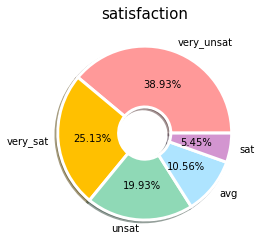

In [18]:
plt.title("satisfaction", fontsize=15)
plt.pie(fake_rating.values, labels = fake_rating.index, 
        autopct = '%.2f%%',
        shadow=True, # 그림자 표시 여부
        colors = ['#ff9999', '#ffc000', '#8fd9b6', '#aee4ff','#d395d0'],
        wedgeprops = {'width':0.7,'edgecolor':'w','linewidth':3}
        #width: 부채꼴 영역 너비,edgecolor: 테두리 색 , linewidth : 라인 두께
       )
plt.show()

매우 불만족, 불만족인 사람은 5926명 중 3488로 반이 넘는다.
하지만 매우 만족인 사람의 수도 적진 않다.(특정)

불만족인 사람이 많지만 굳이 변경하지 않았다 어떤이유일까

#### 1. 연수입

In [19]:
feature='INCOME'

In [20]:
print(fake[feature].mean())
print(real[feature].mean())

76572.106479919
83886.85903316867


- 두 집단의 연수입 평균 차는 약 7300달러 차이, 한화로는 950만원 정도 차이가 난다
- fake집단의 연봉이 상대적으로 적은 편이다
- 경제적으로 여유가 있지 않은 사람들의 경우 변경의사가 있다해도 현실적인 상황을 따져봤을 때 쉽게 바꾸지 못했을 것 같다. 금전적인 부담으로 바꾸지 못할 확률이 있음

#### 2. 대학 졸업 여부

In [21]:
feature='COLLEGE'
tmp=fake[feature].value_counts()/len(fake[feature])
tmp1=fake[feature].value_counts()
print(tmp)

0    0.50945
1    0.49055
Name: COLLEGE, dtype: float64


미졸업자가 50.9%로 졸업하지 않은 학생신분이다. 부모님께서 통신비를 지원해주셔서 통신사에는 불만족스럽지만 쉽사리 바꾸지 못한 상황들이 존재할 것으로 예상한다

#### 3. 월 초과사용 시간

In [22]:
feature='OVERAGE'

In [23]:
fake[feature].describe()

count    5926.000000
mean       66.569524
std        79.563984
min        -2.000000
25%         0.000000
50%        47.000000
75%        82.000000
max       301.000000
Name: OVERAGE, dtype: float64

In [24]:
real[feature].describe()

count    5668.000000
mean      107.133204
std        88.021538
min         0.000000
25%        18.750000
50%        74.000000
75%       194.000000
max       296.000000
Name: OVERAGE, dtype: float64

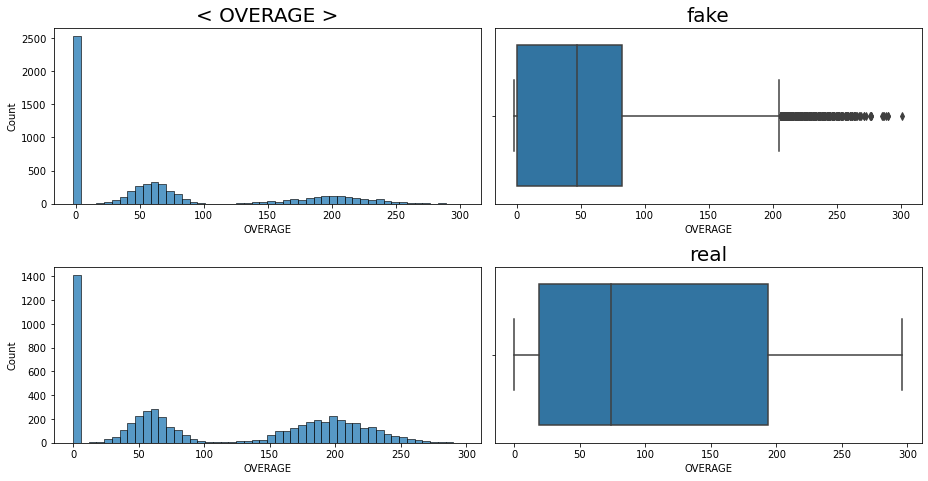

In [25]:
plt.figure(figsize=(13,13))
plt.subplot(4,2,1)
sns.histplot(fake[feature], bins=50)
plt.title("< OVERAGE >", fontsize=20)

plt.subplot(4,2,2)
sns.boxplot(fake[feature])
plt.title("fake", fontsize=20)

plt.subplot(4,2,3)
sns.histplot(real[feature], bins=50)

plt.subplot(4,2,4)
sns.boxplot(real[feature])
plt.title("real", fontsize=20)

plt.tight_layout()
plt.show()

fake vs real

1. real집단보다 fake집단의 통화 초과량이 전체적으로 더 낮음
+ IQR 범위(25% ~ 75% 구간)가 차이가 많이남
> real집단은 통화 초과량과 추가 요금이 비례해 더 이탈 할 이유가 크다

2. fake 집단의 0 구간인 사람이 **두배**로 더 많은걸 알 수 있다 -> 자신의 요금제 안에서 사용하는 비율이 크다는 뜻이다.
> 자신의 요금제를 잘 사용하기 때문에 실제로 이탈하지 않을 가능성이 커보임

3. 유독 40 ~ 80구간과 150 ~ 240 구간에 초과량이 큰 지  분석해봐야 할 필요가 있다
> 이벤트나 프로모션의 영향을 받아 저런 형상의 그래프가 형성 됬을 것 같다

#### 4. 월 사용 잔여시간(%)

In [26]:
feature = 'LEFTOVER'

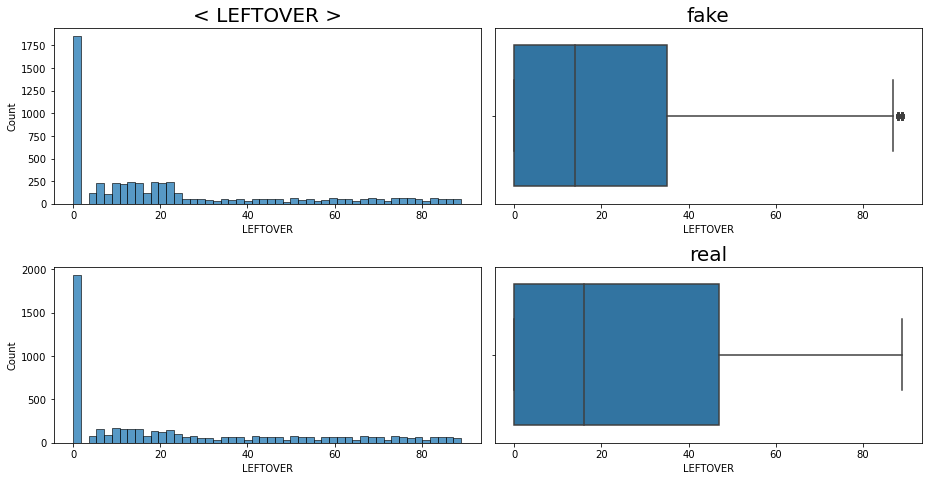

In [27]:
plt.figure(figsize=(13,13))
plt.subplot(4,2,1)
sns.histplot(fake[feature], bins=50)
plt.title("< LEFTOVER >", fontsize=20)

plt.subplot(4,2,2)
sns.boxplot(fake[feature])
plt.title("fake", fontsize=20)

plt.subplot(4,2,3)
sns.histplot(real[feature], bins=50)

plt.subplot(4,2,4)
sns.boxplot(real[feature])
plt.title("real", fontsize=20)

plt.tight_layout()
plt.show()

#### 5. 평균 통화 시간(분)

fake집단의 잔여 시간이 5~25%정도로 밀집하게 모여있음

In [28]:
feature='AVERAGE_CALL_DURATION'

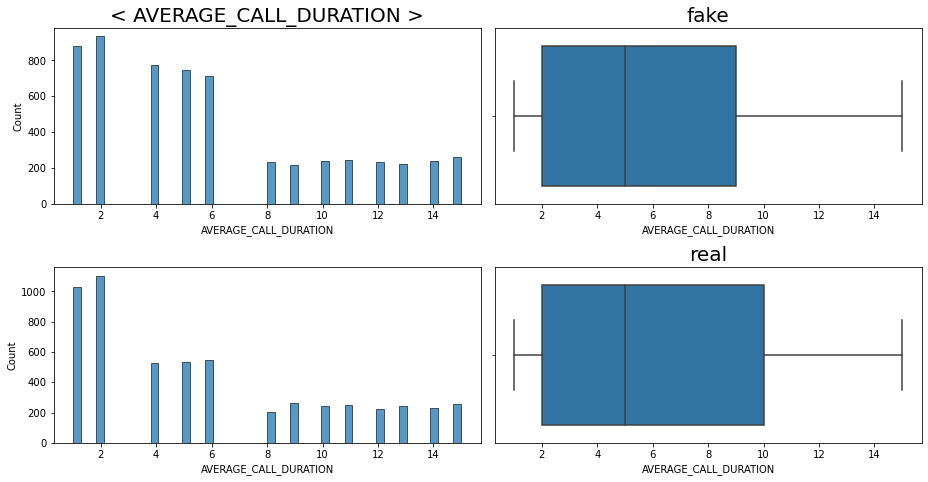

In [29]:
plt.figure(figsize=(13,13))
plt.subplot(4,2,1)
sns.histplot(fake[feature], bins=50)
plt.title("< AVERAGE_CALL_DURATION >", fontsize=20)

plt.subplot(4,2,2)
sns.boxplot(fake[feature])
plt.title("fake", fontsize=20)

plt.subplot(4,2,3)
sns.histplot(real[feature], bins=50)

plt.subplot(4,2,4)
sns.boxplot(real[feature])
plt.title("real", fontsize=20)


plt.tight_layout()
plt.show()

#### 6. 핸드폰 가격(달러)

In [30]:
feature='HANDSET_PRICE'

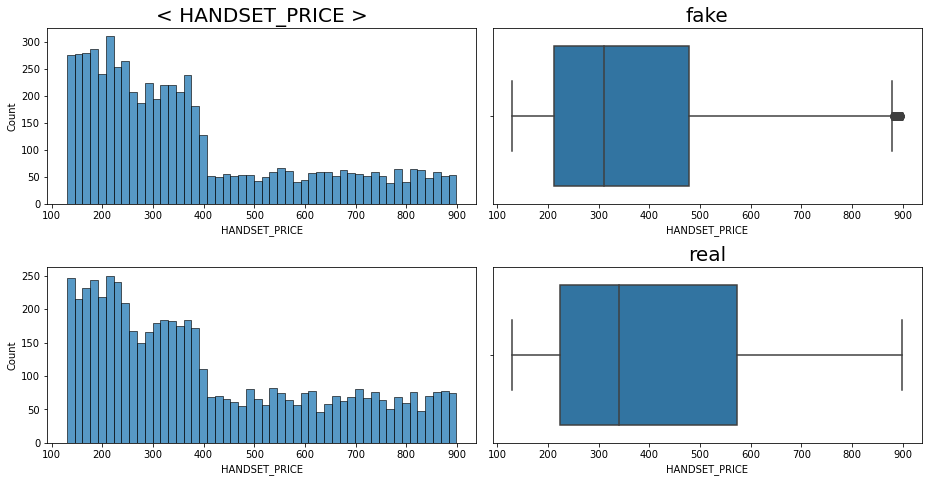

In [31]:
plt.figure(figsize=(13,13))
plt.subplot(4,2,1)
sns.histplot(fake[feature], bins=50)
plt.title("< HANDSET_PRICE >", fontsize=20)

plt.subplot(4,2,2)
sns.boxplot(fake[feature])
plt.title("fake", fontsize=20)

plt.subplot(4,2,3)
sns.histplot(real[feature], bins=50)

plt.subplot(4,2,4)
sns.boxplot(real[feature])
plt.title("real", fontsize=20)

plt.tight_layout()
plt.show()

#### 7. 평균 장기통화(15분 이상) 횟수

In [32]:
feature='OVER_15MINS_CALLS_PER_MONTH'

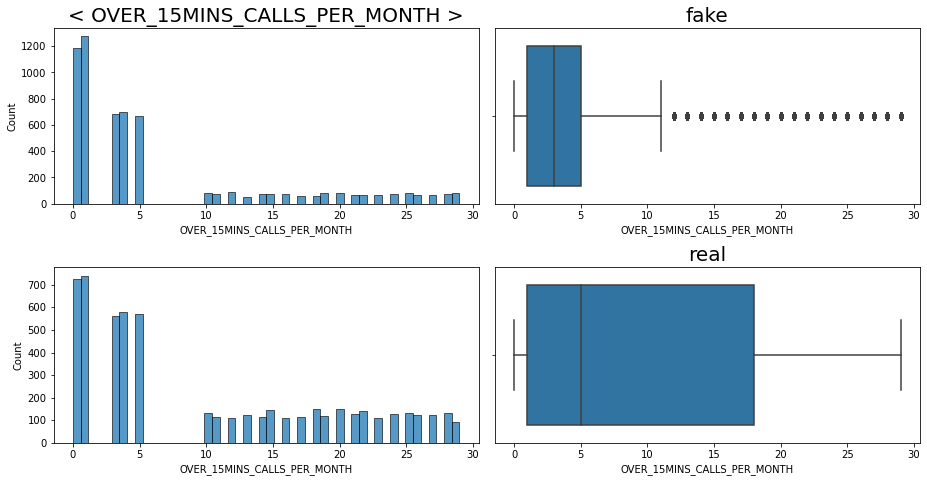

In [33]:
plt.figure(figsize=(13,13))
plt.subplot(4,2,1)
sns.histplot(fake[feature], bins=50)
plt.title("< OVER_15MINS_CALLS_PER_MONTH >", fontsize=20)

plt.subplot(4,2,2)
sns.boxplot(fake[feature])
plt.title("fake", fontsize=20)

plt.subplot(4,2,3)
sns.histplot(real[feature], bins=50)

plt.subplot(4,2,4)
sns.boxplot(real[feature])
plt.title("real", fontsize=20)

plt.tight_layout()
plt.show()

유독 다른 변수보다 fake와 real 집단의 차이가 심하다
- 실제 이탈한 집단(real)에서는 장기 통화 횟수가 상당히 많은 편이다

#### 8. 사용 수준 설문

In [34]:
feature='REPORTED_USAGE_LEVEL'

In [35]:
m_rating=mobile[feature].value_counts()
m_rating

little         7076
very_high      4636
very_little    3594
high           1812
avg             882
Name: REPORTED_USAGE_LEVEL, dtype: int64

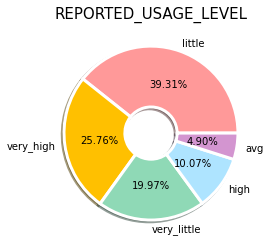

In [36]:
plt.title("REPORTED_USAGE_LEVEL", fontsize=15)
plt.pie(m_rating.values, labels = m_rating.index, 
        autopct = '%.2f%%',
        shadow=True, # 그림자 표시 여부
        colors = ['#ff9999', '#ffc000', '#8fd9b6', '#aee4ff','#d395d0'],
        wedgeprops = {'width':0.7,'edgecolor':'w','linewidth':3}
        #width: 부채꼴 영역 너비,edgecolor: 테두리 색 , linewidth : 라인 두께
       )
plt.show()

little 관련된 설문이 50%로 핸드폰 사용 수준이 많지 않다

그래서 통화/문자/데이터 기본적인 제공에 대해 만족을 하지 않으면 이탈할 가능성이 크다고 본다.

In [37]:
little_grp = real.loc[(real[feature]=='little') | (real[feature]=='very_little')]
little_grp

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
6,6337,1,99548,235,0,238561.000000,294,15,6,very_unsat,little,actively_looking_into_it,1
8,11134,1,133496,163,11,166179.000000,864,10,5,very_unsat,little,actively_looking_into_it,1
23,555,0,42564,174,0,270823.000000,209,25,13,unsat,very_little,considering,1
26,15152,0,80273,218,32,916662.000000,318,19,15,very_unsat,little,considering,1
28,1160,0,69417,52,88,686029.000000,331,3,2,very_unsat,little,actively_looking_into_it,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17981,19860,0,42235,260,19,492950.532696,146,12,6,avg,very_little,considering,1
17984,11568,0,103469,230,0,492950.532696,565,22,13,avg,little,actively_looking_into_it,1
17987,17077,1,44611,56,13,492950.532696,202,3,5,sat,little,actively_looking_into_it,1
17993,17217,1,72824,53,42,492950.532696,370,4,1,very_unsat,very_little,considering,1


real 집단 5668 명 중 3391명, 즉 59.8%의 고객이 핸드폰 사용수준이 많지 않음을 나타냄

-> 그래서 초과사용에 대한 피쳐들만 조사해봄

In [38]:
# 월 초과사용 시간(분)
feature='OVERAGE'
little_grp[feature].describe()

count    3391.000000
mean      108.028900
std        87.489362
min         0.000000
25%        33.000000
50%        76.000000
75%       194.000000
max       288.000000
Name: OVERAGE, dtype: float64

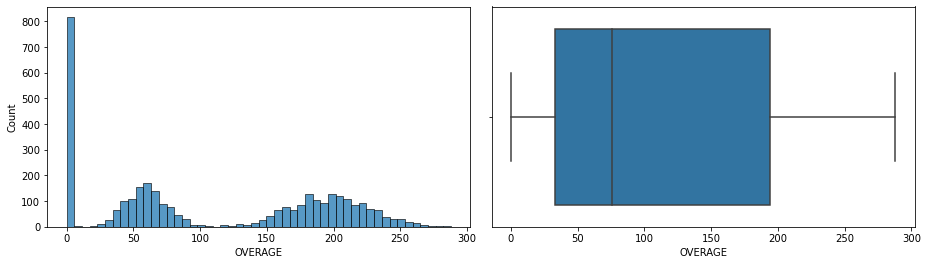

In [39]:
plt.figure(figsize=(13,7))
plt.subplot(2,2,1)
sns.histplot(little_grp[feature], bins=50)

plt.subplot(2,2,2)
sns.boxplot(little_grp[feature])

plt.tight_layout()
plt.show()

In [41]:
# 전체 인원의 평균 장기통화, 평균 초과 통화량
print(df[['OVER_15MINS_CALLS_PER_MONTH','OVERAGE']].mean())

OVER_15MINS_CALLS_PER_MONTH     8.012778
OVERAGE                        86.014833
dtype: float64


In [44]:
col = ['OVERAGE','OVER_15MINS_CALLS_PER_MONTH']
over_little_grp=little_grp[col].loc[(little_grp['OVER_15MINS_CALLS_PER_MONTH']>df['OVER_15MINS_CALLS_PER_MONTH'].mean()) | 
                                   (little_grp['OVERAGE']>df['OVERAGE'].mean())]
over_little_grp

,OVERAGE,OVER_15MINS_CALLS_PER_MONTH
6,235,15
8,163,10
23,174,25
26,218,19
40,158,28
...,...,...
17978,240,22
17980,87,5
17981,260,12
17984,230,22


In [45]:
print(len(over_little_grp)/3391*100)

49.63137717487467


little_grp 총 3391명 중 초과사용량과 장기 통화량의 평균보다 큰 사람들은 1683명

즉, 49.6%

> real 집단(실제 이탈집단)에서 사용량이 적다고 설문 해던 사람들 중  월 초과사용량과 장기 통화량이 평균보다 많은 사람들이 49.6%로 나왔다

> 이것을 보았을 때 설문과 데이터의 모순점이라고 생각된다.